# Задание по SQL
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.
 - room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
 - price – цена за ночь
 - first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение поставьте на 1000 строк.
Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [24]:
pip install pandahouse

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/tljh/user/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np

In [26]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student',
                      'password':'dpo_python_2020'
                     }

In [7]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, --убираем значок доллара и переводим в флоат
    first_review
FROM
        ldn_listings
WHERE
    first_review > '2010-01-01'
--ORDER BY
--    first_review DESC
LIMIT 1000
'''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [19]:
# Оставляем только первые 4 символа даты чтобы получить год
q_test ['first_review'] = q_test['first_review'].str[:4]
q_test.head()

,room_type,price,first_review,price_log
0,Private room,65.0,2010,4.174387
1,Entire home/apt,300.0,2011,5.703783
2,Entire home/apt,65.0,2016,4.174387
3,Private room,29.0,2010,3.367296
4,Private room,100.0,2010,4.605170


In [21]:
# группируем по типу комнаты и году, в качестве агрегирующей средняя цена
q_test2=q_test \
    .groupby(['room_type', 'first_review']) \
    .agg ({'price': 'mean'}).reset_index()
q_test2.head()

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328


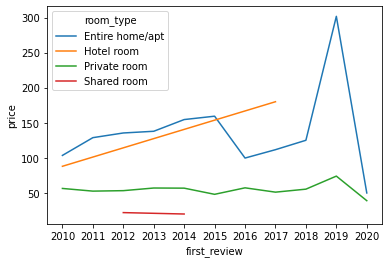

In [12]:
# выводим график
sns.lineplot(x='first_review', y='price', hue='room_type', data=q_test2)

Далее постройте два графика, используя distplot из библиотеки seaborn:
- На первом отобразите исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения

In [22]:
# добавляем колонку с переводом цены в логарифм
q_test ['price_log'] = np.log(q_test.price)
q_test.head()

,room_type,price,first_review,price_log
0,Private room,65.0,2010,4.174387
1,Entire home/apt,300.0,2011,5.703783
2,Entire home/apt,65.0,2016,4.174387
3,Private room,29.0,2010,3.367296
4,Private room,100.0,2010,4.605170


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


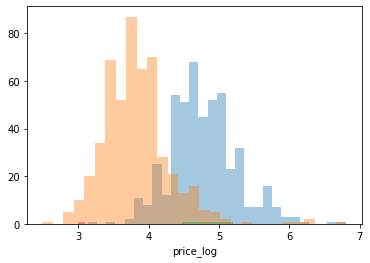

In [15]:
# строим глафики по логарифмическим ценам, фильтруя отдельно каждый тип компнаты чтобы у них был разный цвет
ax = sns.distplot(q_test.query("room_type == 'Entire home/apt'").price_log, kde=False)
ax = sns.distplot(q_test.query("room_type == 'Private room'").price_log, kde=False)
ax = sns.distplot(q_test.query("room_type == 'Hotel room'").price_log, kde=False)
ax = sns.distplot(q_test.query("room_type == 'Shared room'").price_log, kde=False)

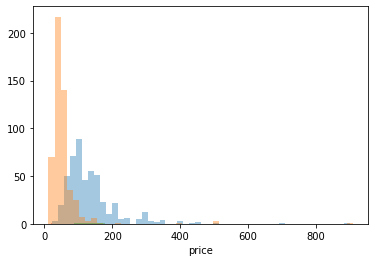

In [16]:
# строим глафики по обычным ценам, фильтруя отдельно каждый тип компнаты чтобы у них был разный цвет
sns.distplot(q_test.query("room_type == 'Entire home/apt'").price, kde=False)
sns.distplot(q_test.query("room_type == 'Private room'").price, kde=False)
sns.distplot(q_test.query("room_type == 'Hotel room'").price, kde=False)
sns.distplot(q_test.query("room_type == 'Shared room'").price, kde=False)